# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains 10 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model.

***


Use the below cell to use any include any imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

## Section 1: Preparing the vocabulary

In [ ]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [ ]:
with open('wordlist.txt', 'r') as file:
    words = file.read().splitlines()

vocab = [word.lower() for word in words if len(word) > 3 and len(word) <= WORD_SIZE]
vocab = [word.ljust(WORD_SIZE, '_') for word in vocab]
print(vocab[:10])  # Show first 10 words


['aaron________', 'abandoned____', 'aberdeen_____', 'abilities____', 'ability______', 'able_________', 'aboriginal___', 'abortion_____', 'about________', 'above________']


<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

**Answer** (to write answers edit this cell)
1.   Reducing Complexity and Model Size - Limiting the word length reduces the total number of characters the model needs to process, which directly reduces the complexity of the model. Fewer parameters mean faster training and lower computational requirements.

1.    Improving Data Quality - Very short words (like "a", "an", "to", "is") may not be useful for word autocompletion since they don’t provide enough information to build a meaningful prediction. Removing words shorter than 3 characters filters out these noisy and less informative data points.
2.  Memory and Efficiency Constraints - If include extremely long words, the amount of memory required to store and process sequences increases for deep learning models. This can lead to slower training and potential memory issues.


**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [ ]:
def char_to_num(char):
    if char == '_':
        return 0
    else:
        return ord(char) - ord('a') + 1


def num_to_char(num):
    if num == 0:
        return '_'
    else:
        return chr(num + ord('a') - 1)

def word_to_numlist(word):
    numlist = [char_to_num(char) for char in word]
    return torch.tensor(numlist)

def numlist_to_word(numlist):
    word = ''.join([num_to_char(num.item()) for num in numlist])
    return word


<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font>

**Answer** (to write answers edit this cell)

**Why Alphabetical Order Encoding is Not Ideal:**

1.   Imposes False Relationships: When we map letters to numbers based on alphabetical order, we introduce an unintended ordinal relationship between them. For example, 'a' becomes 1, 'b' becomes 2, and so on, implying that 'b' is somehow "larger" or "closer" to 'a' than 'z'. In reality, letters don't have such a natural order, and this ordering creates a false sense of proximity between letters, which can confuse the learning process.
2.   Equal Distance Assumption: In numerical encoding, the model may assume that the distance between consecutive letters (like 'a' and 'b') is the same as the distance between letters far apart (like 'a' and 'z'). This assumption is not true and leads to inefficiencies in learning.
3.  Lack of Semantic Representation: The simple alphabetical encoding does not capture any meaningful relationship between letters or how they appear in different contexts (e.g., 'q' is often followed by 'u'). As a result, the model may struggle to generalize patterns in the data.

**What is an Embedding Layer?**
An embedding layer is a type of neural network layer that maps discrete input data (like letters or words) to continuous-valued dense vectors in a lower-dimensional space. Each letter is represented as a multi-dimensional vector where each dimension captures some feature or aspect of the letter.

**Purpose of an Embedding Layer:**

1.   Capturing Semantic Relationships: Unlike the naive alphabetical encoding, an embedding layer learns to represent each letter (or word) as a vector where the distance between vectors reflects meaningful relationships.
2.   Dimensionality Reduction: Embedding layers project high-dimensional data (like the 27 unique characters) into a much lower-dimensional vector space, which simplifies the model's learning process without losing the necessary information.
3. Learning from Data: Embeddings are not hard-coded but learned during training. The model adjusts the vectors based on how useful they are for predicting outputs. This way, the model can capture more complex relationships and patterns between letters based on the specific task.












## Section 2: Implementing the Autocomplete model

We will implement a RNN model based on LSTM. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [ ]:
LEARNING_RATE = 0.005

In [ ]:
class autocompleteModel(nn.Module):

    #Constructor
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()
        self.alphabet_size = alphabet_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(alphabet_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, alphabet_size)


    def forward(self, character, hidden_state, cell_state):
        embedded = self.embedding(character)
        lstm_out, (hidden_state, cell_state) = self.lstm(embedded.view(1, 1, -1), (hidden_state, cell_state))
        output = self.fc(lstm_out.view(-1))
        return output, hidden_state, cell_state


    def initial_state(self):
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        c0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        return (h0, c0)


    def trainModel(self, vocab, epochs = 5, batch_size = 100):
        self.train()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        loss_log = []
        criterion = nn.CrossEntropyLoss()

        for e in range(epochs):
            random.shuffle(vocab)
            num_iter = len(vocab) // batch_size

            for i in range(num_iter):
                optimizer.zero_grad()
                total_loss = 0
                vocab_batch = vocab[i * batch_size: (i + 1) * batch_size]

                for word in vocab_batch:
                    hidden_state, cell_state = self.initial_state()
                    input_word = torch.tensor([char_to_num(c) for c in word[:-1]], dtype=torch.long)
                    target_word = torch.tensor([char_to_num(c) for c in word[1:]], dtype=torch.long)

                    for c in range(WORD_SIZE - 1):
                        output, hidden_state, cell_state = self.forward(input_word[c], hidden_state, cell_state)
                        loss = F.cross_entropy(output.view(1, -1), target_word[c].view(-1))
                        total_loss += loss


                total_loss /= batch_size
                total_loss.backward()
                optimizer.step()
                loss_log.append(loss.item())

            print("Epoch: ", e)

        plt.plot(loss_log)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Loss variation over training')
        plt.show()

    def autocomplete(self, sample):
        self.eval()
        completed_list = []

        for literal in sample:
            hidden_state, cell_state = self.initial_state()
            input_chars = torch.tensor([char_to_num(c) for c in literal], dtype=torch.long)

            for c in input_chars:
                output, hidden_state, cell_state = self.forward(c, hidden_state, cell_state)

            for _ in range(WORD_SIZE - len(literal)):
                output = F.softmax(output, dim=0)
                next_char = torch.multinomial(output, 1).item()
                literal += num_to_char(next_char)
                output, hidden_state, cell_state = self.forward(torch.tensor([next_char]), hidden_state, cell_state)

            completed_list.append(literal)

        return(completed_list)

## Section 3: Using and evaluating the model

(i) Feel free to initialize a autocompleteModel using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can. Show the loss curves in you answers.

(ii) Evaluate it on different samples of partially filled in words. Eg: ["univ", "math", "neur", "engin"] etc. Please show outputs for different samples.

<font color='blue'>Comment on the results. Is it successful? Do you see familiar substrings in the generated tesxt such as "tion", "ing", "able" etc. What are your suggestions to improve the model?</font>

**Answer** (to write answers edit this cell)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19


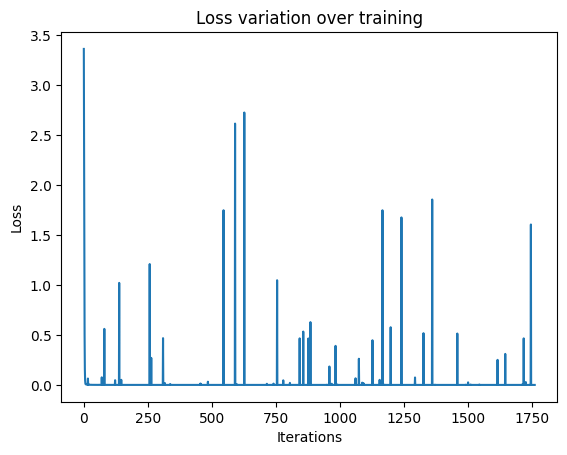

In [ ]:
alphabet_size = 27
embed_dim = 50
hidden_size = 128
num_layers =1
learning_rate = 0.005
epochs =20
batch_size = 100


model = autocompleteModel(alphabet_size, embed_dim, hidden_size, num_layers)
model.trainModel(vocab, epochs,batch_size)



In [10]:
samples = ["univ", "math", "neur", "engin"]
completed_words = model.autocomplete(samples)
print("Autocompleted words:", completed_words)

Autocompleted words: ['university___', 'mathed_______', 'neurs________', 'engineer_____']


**Results Overview**

* 'university' is a correct and fully completed word from the sample input 'univ', which shows that the model successfully learned some patterns for common words.
*   The word 'mathed' seems like a non-existent word, indicating the model might have struggled to predict an appropriate ending for this partial input ('math').

*  'neurs' is an incomplete prediction of 'neuroscience' or 'neural', suggesting that the model struggled to complete the word accurately beyond a certain length.
*   'engineer' is a good completion of 'engin', which is a common word. The model successfully autocompleted this familiar word.

The model is partially successful, especially for commonly used or well-known words like "university" and "engineer".The result 'engineer' shows a familiar word ending that is often found in the context of engineering terms. It struggles, however, with more uncommon word fragments like 'math' and 'neur', leading to strange completions.

**Suggestions for Improvement**



*   Increase the Size of the Hidden Layer
*   More Epochs for Training
*   Use a Larger and More Varied Vocabulary
*   Experiment with Different Embedding Dimensions
*   Increase Batch Size





